# Notebook 3: Model Training and Evaluation

## Objective

This notebook implements and trains our hybrid **1D CNN + LSTM Autoencoder** for intrusion detection. We will:

1. Load preprocessed sequential data
2. Build the CNN+LSTM Autoencoder architecture
3. Train the model on normal traffic only
4. Evaluate using reconstruction error
5. Detect intrusions (anomalies)
6. Generate comprehensive performance metrics
7. Visualize results and model performance

---

## Background: Autoencoder-Based Anomaly Detection

### What is an Autoencoder?
An autoencoder is an unsupervised neural network that:
- **Encodes** input data into a compressed latent representation
- **Decodes** the latent representation back to original format
- Learns to **reconstruct** its input

### Why for Intrusion Detection?
1. Train only on **normal traffic** (no need for labeled attacks during training)
2. Model learns patterns of normal behavior
3. Attack traffic will have **high reconstruction error** (anomaly)
4. Set threshold: high error = intrusion detected!

### Our Hybrid Architecture:
- **1D CNN layers**: Extract spatial features from each flow's features
- **LSTM Encoder**: Capture temporal dependencies across sequence
- **LSTM Decoder**: Reconstruct the original sequence
- **Output**: Reconstructed sequence

---

## Step 1: Import Required Libraries

We'll use TensorFlow/Keras for building our deep learning model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, RepeatVector, TimeDistributed, Dropout

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(" Libraries imported successfully!")

2025-12-15 04:47:41.692528: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-15 04:47:41.703827: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 04:47:42.176524: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 04:47:44.158538: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

TensorFlow version: 2.20.0
GPU Available: []
 Libraries imported successfully!


E0000 00:00:1765766864.602379   49264 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765766864.623297   49264 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Step 2: Load Preprocessed Data

We'll load the sequences created in Notebook 1.

In [2]:
# Load preprocessed sequences
print(" Loading preprocessed data...")
X_train = np.load('preprocessed_data/X_train.npy')
X_train_normal = np.load('preprocessed_data/X_train_normal.npy')
X_val = np.load('preprocessed_data/X_val.npy')
X_test = np.load('preprocessed_data/X_test.npy')
y_train = np.load('preprocessed_data/y_train.npy')
y_val = np.load('preprocessed_data/y_val.npy')
y_test = np.load('preprocessed_data/y_test.npy')

# Load feature names
with open('preprocessed_data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"\n Data loaded successfully!")
print(f"\nData Shapes:")
print(f"   - X_train: {X_train.shape}")
print(f"   - X_train_normal (for autoencoder): {X_train_normal.shape}")
print(f"   - X_val: {X_val.shape}")
print(f"   - X_test: {X_test.shape}")
print(f"\nSequence Info:")
print(f"   - Sequence length: {X_train.shape[1]} flows")
print(f"   - Features per flow: {X_train.shape[2]}")

 Loading preprocessed data...

 Data loaded successfully!

Data Shapes:
   - X_train: (36073, 10, 42)
   - X_train_normal (for autoencoder): (11887, 10, 42)
   - X_val: (7730, 10, 42)
   - X_test: (7730, 10, 42)

Sequence Info:
   - Sequence length: 10 flows
   - Features per flow: 42


## Step 3: Build the CNN+LSTM Autoencoder Architecture

Our model consists of:

### Encoder:
1. **1D CNN layers**: Extract features from each time step
2. **LSTM layers**: Encode temporal dependencies

### Decoder:
1. **RepeatVector**: Repeat latent representation for each time step
2. **LSTM layers**: Decode temporal information
3. **TimeDistributed Dense**: Reconstruct features for each time step

In [3]:
def build_cnn_lstm_autoencoder(sequence_length, n_features, latent_dim=32):
    """
    Build a hybrid 1D CNN + LSTM Autoencoder for sequence anomaly detection.
    
    Parameters:
    -----------
    sequence_length : int
        Length of input sequences (number of time steps)
    n_features : int
        Number of features at each time step
    latent_dim : int
        Dimension of the latent (compressed) representation
    
    Returns:
    --------
    model : keras.Model
        Compiled autoencoder model
    """
    
    # Input layer
    inputs = Input(shape=(sequence_length, n_features))
    
    # =====================
    # ENCODER
    # =====================
    
    # 1D CNN layers for spatial feature extraction
    # These extract patterns within each time step's features
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Dropout(0.2)(x)
    
    # LSTM Encoder - captures temporal dependencies
    # return_sequences=False means only return the final hidden state
    encoded = LSTM(latent_dim, activation='relu', name='encoder_lstm')(x)
    
    # =====================
    # DECODER
    # =====================
    
    # Repeat the latent representation for each time step
    x = RepeatVector(sequence_length)(encoded)
    
    # LSTM Decoder - reconstructs temporal patterns
    x = LSTM(latent_dim, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    
    x = LSTM(32, activation='relu', return_sequences=True)(x)
    x = Dropout(0.2)(x)
    
    # TimeDistributed Dense layer to reconstruct features at each time step
    decoded = TimeDistributed(Dense(n_features))(x)
    
    # =====================
    # CREATE MODEL
    # =====================
    
    autoencoder = Model(inputs, decoded, name='CNN_LSTM_Autoencoder')
    
    # Compile with MSE loss (reconstruction error)
    autoencoder.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return autoencoder

# Get dimensions from data
sequence_length = X_train.shape[1]
n_features = X_train.shape[2]

# Build the model
print(" Building CNN+LSTM Autoencoder...")
autoencoder = build_cnn_lstm_autoencoder(
    sequence_length=sequence_length,
    n_features=n_features,
    latent_dim=32
)

print("\n Model built successfully!")
print("\n Model Summary:")
autoencoder.summary()

 Building CNN+LSTM Autoencoder...

 Model built successfully!

 Model Summary:


Model: "CNN_LSTM_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 10, 64)         │         8,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_lstm (LSTM)             │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 42)         │         1,386 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,650 (158.79 KB)

 Trainable params: 40,650 (158.79 KB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Visualize Model Architecture

Let's visualize our model structure to better understand the data flow.

In [4]:
# Plot model architecture
keras.utils.plot_model(
    autoencoder,
    to_file='saved_models/model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

print(" Model architecture saved to 'saved_models/model_architecture.png'")

You must install pydot (`pip install pydot`) for `plot_model` to work.
 Model architecture saved to 'saved_models/model_architecture.png'


## Step 5: Set Up Training Callbacks

Callbacks help us:
- Save the best model
- Stop training early if no improvement
- Reduce learning rate when stuck

In [5]:
# Create directory for saving models
os.makedirs('saved_models', exist_ok=True)

# Define callbacks
checkpoint = callbacks.ModelCheckpoint(
    'saved_models/best_autoencoder.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callback_list = [checkpoint, early_stopping, reduce_lr]

print("✅ Training callbacks configured!")

✅ Training callbacks configured!


## Step 6: Train the Autoencoder on Normal Traffic

**Key Point**: We train ONLY on normal traffic so the model learns normal behavior patterns. Attack traffic will have high reconstruction error.

In [6]:
# Extract normal sequences from validation set for validation during training
X_val_normal = X_val[y_val == 0]

print(f" Training on NORMAL traffic only:")
print(f"   - Training samples: {X_train_normal.shape[0]:,}")
print(f"   - Validation samples: {X_val_normal.shape[0]:,}")
print(f"\n Starting training...\n")

# Train the autoencoder
history = autoencoder.fit(
    X_train_normal, X_train_normal,  # Input = Output for autoencoder
    epochs=80,
    batch_size=64,
    validation_data=(X_val_normal, X_val_normal),
    callbacks=callback_list,
    verbose=1
)

print("\n Training completed!")

 Training on NORMAL traffic only:
   - Training samples: 11,887
   - Validation samples: 2,547

 Starting training...

Epoch 1/80
  1/186 ━━━━━━━━━━━━━━━━━━━━ 13:32 4s/step - loss: 0.0872 - mae: 0.1234

2025-12-15 04:47:49.654336: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0600 - mae: 0.1235
Epoch 1: val_loss improved from None to 0.02100, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.0425 - mae: 0.1130 - val_loss: 0.0210 - val_mae: 0.0692 - learning_rate: 0.0010
Epoch 2/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0233 - mae: 0.0808
Epoch 2: val_loss improved from 0.02100 to 0.01889, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0224 - mae: 0.0762 - val_loss: 0.0189 - val_mae: 0.0597 - learning_rate: 0.0010
Epoch 3/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0207 - mae: 0.0683
Epoch 3: val_loss improved from 0.01889 to 0.01792, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0203 - mae: 0.0669 - val_loss: 0.0179 - val_mae: 0.0573 - learning_rate: 0.0010
Epoch 4/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0195 - mae: 0.0638
Epoch 4: val_loss improved from 0.01792 to 0.01707, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0194 - mae: 0.0631 - val_loss: 0.0171 - val_mae: 0.0544 - learning_rate: 0.0010
Epoch 5/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0187 - mae: 0.0614
Epoch 5: val_loss improved from 0.01707 to 0.01633, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0185 - mae: 0.0609 - val_loss: 0.0163 - val_mae: 0.0528 - learning_rate: 0.0010
Epoch 6/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0179 - mae: 0.0593
Epoch 6: val_loss improved from 0.01633 to 0.01569, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0179 - mae: 0.0590 - val_loss: 0.0157 - val_mae: 0.0513 - learning_rate: 0.0010
Epoch 7/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0173 - mae: 0.0576
Epoch 7: val_loss improved from 0.01569 to 0.01497, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0172 - mae: 0.0572 - val_loss: 0.0150 - val_mae: 0.0500 - learning_rate: 0.0010
Epoch 8/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0166 - mae: 0.0561
Epoch 8: val_loss improved from 0.01497 to 0.01437, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0165 - mae: 0.0557 - val_loss: 0.0144 - val_mae: 0.0486 - learning_rate: 0.0010
Epoch 9/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0160 - mae: 0.0546
Epoch 9: val_loss improved from 0.01437 to 0.01367, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0159 - mae: 0.0543 - val_loss: 0.0137 - val_mae: 0.0472 - learning_rate: 0.0010
Epoch 10/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0155 - mae: 0.0534
Epoch 10: val_loss improved from 0.01367 to 0.01305, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0154 - mae: 0.0531 - val_loss: 0.0131 - val_mae: 0.0460 - learning_rate: 0.0010
Epoch 11/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0149 - mae: 0.0524
Epoch 11: val_loss improved from 0.01305 to 0.01250, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0148 - mae: 0.0520 - val_loss: 0.0125 - val_mae: 0.0446 - learning_rate: 0.0010
Epoch 12/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0144 - mae: 0.0511
Epoch 12: val_loss improved from 0.01250 to 0.01192, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0142 - mae: 0.0507 - val_loss: 0.0119 - val_mae: 0.0436 - learning_rate: 0.0010
Epoch 13/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0139 - mae: 0.0500
Epoch 13: val_loss improved from 0.01192 to 0.01121, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0138 - mae: 0.0496 - val_loss: 0.0112 - val_mae: 0.0418 - learning_rate: 0.0010
Epoch 14/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0135 - mae: 0.0489
Epoch 14: val_loss improved from 0.01121 to 0.01085, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0133 - mae: 0.0485 - val_loss: 0.0108 - val_mae: 0.0408 - learning_rate: 0.0010
Epoch 15/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0130 - mae: 0.0479
Epoch 15: val_loss improved from 0.01085 to 0.01036, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0129 - mae: 0.0476 - val_loss: 0.0104 - val_mae: 0.0394 - learning_rate: 0.0010
Epoch 16/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0125 - mae: 0.0468
Epoch 16: val_loss improved from 0.01036 to 0.00998, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0125 - mae: 0.0466 - val_loss: 0.0100 - val_mae: 0.0387 - learning_rate: 0.0010
Epoch 17/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0122 - mae: 0.0461
Epoch 17: val_loss did not improve from 0.00998
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0122 - mae: 0.0460 - val_loss: 0.0100 - val_mae: 0.0386 - learning_rate: 0.0010
Epoch 18/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0120 - mae: 0.0455
Epoch 18: val_loss improved from 0.00998 to 0.00978, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0119 - mae: 0.0453 - val_loss: 0.0098 - val_mae: 0.0382 - learning_rate: 0.0010
Epoch 19/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0117 - mae: 0.0448
Epoch 19: val_loss improved from 0.00978 to 0.00958, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0116 - mae: 0.0447 - val_loss: 0.0096 - val_mae: 0.0377 - learning_rate: 0.0010
Epoch 20/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0115 - mae: 0.0443
Epoch 20: val_loss improved from 0.00958 to 0.00944, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0114 - mae: 0.0442 - val_loss: 0.0094 - val_mae: 0.0373 - learning_rate: 0.0010
Epoch 21/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0113 - mae: 0.0439
Epoch 21: val_loss improved from 0.00944 to 0.00923, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0113 - mae: 0.0437 - val_loss: 0.0092 - val_mae: 0.0366 - learning_rate: 0.0010
Epoch 22/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0112 - mae: 0.0436
Epoch 22: val_loss improved from 0.00923 to 0.00912, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0112 - mae: 0.0434 - val_loss: 0.0091 - val_mae: 0.0369 - learning_rate: 0.0010
Epoch 23/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0110 - mae: 0.0432
Epoch 23: val_loss improved from 0.00912 to 0.00895, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0110 - mae: 0.0431 - val_loss: 0.0089 - val_mae: 0.0358 - learning_rate: 0.0010
Epoch 24/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0109 - mae: 0.0428
Epoch 24: val_loss improved from 0.00895 to 0.00889, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0109 - mae: 0.0427 - val_loss: 0.0089 - val_mae: 0.0364 - learning_rate: 0.0010
Epoch 25/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0108 - mae: 0.0426
Epoch 25: val_loss improved from 0.00889 to 0.00884, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0108 - mae: 0.0425 - val_loss: 0.0088 - val_mae: 0.0355 - learning_rate: 0.0010
Epoch 26/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mae: 0.0422
Epoch 26: val_loss improved from 0.00884 to 0.00871, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0106 - mae: 0.0421 - val_loss: 0.0087 - val_mae: 0.0354 - learning_rate: 0.0010
Epoch 27/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mae: 0.0420
Epoch 27: val_loss improved from 0.00871 to 0.00860, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0106 - mae: 0.0419 - val_loss: 0.0086 - val_mae: 0.0352 - learning_rate: 0.0010
Epoch 28/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0106 - mae: 0.0419
Epoch 28: val_loss improved from 0.00860 to 0.00856, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0105 - mae: 0.0418 - val_loss: 0.0086 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 29/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104 - mae: 0.0416
Epoch 29: val_loss improved from 0.00856 to 0.00850, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0104 - mae: 0.0414 - val_loss: 0.0085 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 30/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0104 - mae: 0.0414
Epoch 30: val_loss improved from 0.00850 to 0.00843, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0103 - mae: 0.0413 - val_loss: 0.0084 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 31/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0102 - mae: 0.0412
Epoch 31: val_loss improved from 0.00843 to 0.00837, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0102 - mae: 0.0411 - val_loss: 0.0084 - val_mae: 0.0342 - learning_rate: 0.0010
Epoch 32/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0102 - mae: 0.0409
Epoch 32: val_loss improved from 0.00837 to 0.00829, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0102 - mae: 0.0409 - val_loss: 0.0083 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 33/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0101 - mae: 0.0409
Epoch 33: val_loss improved from 0.00829 to 0.00818, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0101 - mae: 0.0408 - val_loss: 0.0082 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 34/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0100 - mae: 0.0406
Epoch 34: val_loss improved from 0.00818 to 0.00814, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0100 - mae: 0.0406 - val_loss: 0.0081 - val_mae: 0.0343 - learning_rate: 0.0010
Epoch 35/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0100 - mae: 0.0406
Epoch 35: val_loss improved from 0.00814 to 0.00809, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0100 - mae: 0.0405 - val_loss: 0.0081 - val_mae: 0.0336 - learning_rate: 0.0010
Epoch 36/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0099 - mae: 0.0403
Epoch 36: val_loss improved from 0.00809 to 0.00805, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0099 - mae: 0.0403 - val_loss: 0.0080 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 37/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - mae: 0.0402
Epoch 37: val_loss improved from 0.00805 to 0.00802, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0098 - mae: 0.0401 - val_loss: 0.0080 - val_mae: 0.0333 - learning_rate: 0.0010
Epoch 38/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - mae: 0.0402
Epoch 38: val_loss improved from 0.00802 to 0.00799, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0098 - mae: 0.0401 - val_loss: 0.0080 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 39/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0098 - mae: 0.0401
Epoch 39: val_loss improved from 0.00799 to 0.00794, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0097 - mae: 0.0399 - val_loss: 0.0079 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 40/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0097 - mae: 0.0399
Epoch 40: val_loss improved from 0.00794 to 0.00784, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0097 - mae: 0.0399 - val_loss: 0.0078 - val_mae: 0.0332 - learning_rate: 0.0010
Epoch 41/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096 - mae: 0.0398
Epoch 41: val_loss improved from 0.00784 to 0.00778, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0096 - mae: 0.0397 - val_loss: 0.0078 - val_mae: 0.0329 - learning_rate: 0.0010
Epoch 42/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096 - mae: 0.0396
Epoch 42: val_loss did not improve from 0.00778
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0095 - mae: 0.0396 - val_loss: 0.0078 - val_mae: 0.0325 - learning_rate: 0.0010
Epoch 43/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0096 - mae: 0.0397
Epoch 43: val_loss improved from 0.00778 to 0.00773, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0095 - mae: 0.0396 - val_loss: 0.0077 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 44/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0095 - mae: 0.0395
Epoch 44: val_loss did not improve from 0.00773
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0095 - mae: 0.0395 - val_loss: 0.0078 - val_mae: 0.0327 - learning_rate: 0.0010
Epoch 45/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0095 - mae: 0.0395
Epoch 45: val_loss did not improve from 0.00773
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0095 - mae: 0.0394 - val_loss: 0.0077 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 46/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - mae: 0.0393
Epoch 46: val_loss improved from 0.00773 to 0.00768, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0094 - mae: 0.0393 - val_loss: 0.0077 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 47/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - mae: 0.0392
Epoch 47: val_loss improved from 0.00768 to 0.00764, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0094 - mae: 0.0393 - val_loss: 0.0076 - val_mae: 0.0324 - learning_rate: 0.0010
Epoch 48/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0094 - mae: 0.0393
Epoch 48: val_loss did not improve from 0.00764

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0094 - mae: 0.0392 - val_loss: 0.0077 - val_mae: 0.0322 - learning_rate: 0.0010
Epoch 49/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0092 - mae: 0.0388
Epoch 49: val_loss improved from 0.00764 to 0.00757, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0092 - mae: 0.0387 - val_loss: 0.0076 - val_mae: 0.0315 - learning_rate: 5.0000e-04
Epoch 50/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091 - mae: 0.0386
Epoch 50: val_loss improved from 0.00757 to 0.00752, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0092 - mae: 0.0386 - val_loss: 0.0075 - val_mae: 0.0313 - learning_rate: 5.0000e-04
Epoch 51/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091 - mae: 0.0386
Epoch 51: val_loss did not improve from 0.00752
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0091 - mae: 0.0386 - val_loss: 0.0075 - val_mae: 0.0316 - learning_rate: 5.0000e-04
Epoch 52/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091 - mae: 0.0386
Epoch 52: val_loss did not improve from 0.00752
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0092 - mae: 0.0386 - val_loss: 0.0075 - val_mae: 0.0316 - learning_rate: 5.0000e-04
Epoch 53/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091 - mae: 0.0385
Epoch 53: val_loss improved from 0.00752 to 0.00748, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0091 - mae: 0.0385 - val_loss: 0.0075 - val_mae: 0.0312 - learning_rate: 5.0000e-04
Epoch 54/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0091 - mae: 0.0385
Epoch 54: val_loss did not improve from 0.00748

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0091 - mae: 0.0385 - val_loss: 0.0075 - val_mae: 0.0314 - learning_rate: 5.0000e-04
Epoch 55/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mae: 0.0384
Epoch 55: val_loss improved from 0.00748 to 0.00745, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0090 - mae: 0.0383 - val_loss: 0.0074 - val_mae: 0.0309 - learning_rate: 2.5000e-04
Epoch 56/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mae: 0.0383
Epoch 56: val_loss improved from 0.00745 to 0.00744, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0090 - mae: 0.0383 - val_loss: 0.0074 - val_mae: 0.0308 - learning_rate: 2.5000e-04
Epoch 57/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mae: 0.0382
Epoch 57: val_loss did not improve from 0.00744
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0381 - val_loss: 0.0075 - val_mae: 0.0309 - learning_rate: 2.5000e-04
Epoch 58/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mae: 0.0382
Epoch 58: val_loss improved from 0.00744 to 0.00743, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0090 - mae: 0.0382 - val_loss: 0.0074 - val_mae: 0.0308 - learning_rate: 2.5000e-04
Epoch 59/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - mae: 0.0381
Epoch 59: val_loss did not improve from 0.00743
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0381 - val_loss: 0.0074 - val_mae: 0.0309 - learning_rate: 2.5000e-04
Epoch 60/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - mae: 0.0382
Epoch 60: val_loss improved from 0.00743 to 0.00742, saving model to saved_models/best_autoencoder.h5



Epoch 60: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0090 - mae: 0.0382 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 2.5000e-04
Epoch 61/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0381
Epoch 61: val_loss improved from 0.00742 to 0.00740, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 1.2500e-04
Epoch 62/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0381
Epoch 62: val_loss did not improve from 0.00740
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 1.2500e-04
Epoch 63/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0380
Epoch 63: val_loss improved from 0.00740 to 0.00739, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 1.2500e-04
Epoch 64/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0381
Epoch 64: val_loss did not improve from 0.00739
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 1.2500e-04
Epoch 65/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0380
Epoch 65: val_loss did not improve from 0.00739

Epoch 65: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0308 - learning_rate: 1.2500e-04
Epoch 66/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0380
Epoch 66: val_loss did not improve from 0.00739
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0089 - mae: 0.0380 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rat

186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0088 - mae: 0.0378 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 3.1250e-05
Epoch 74/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0379
Epoch 74: val_loss did not improve from 0.00739
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0088 - mae: 0.0378 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 3.1250e-05
Epoch 75/80
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0089 - mae: 0.0380
Epoch 75: val_loss improved from 0.00739 to 0.00739, saving model to saved_models/best_autoencoder.h5



Epoch 75: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0088 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 3.1250e-05
Epoch 76/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0379
Epoch 76: val_loss did not improve from 0.00739
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0088 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 1.5625e-05
Epoch 77/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0379
Epoch 77: val_loss did not improve from 0.00739
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0088 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0307 - learning_rate: 1.5625e-05
Epoch 78/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0378
Epoch 78: val_loss improved from 0.00739 to 0.00739, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0088 - mae: 0.0378 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 1.5625e-05
Epoch 79/80
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0379
Epoch 79: val_loss improved from 0.00739 to 0.00739, saving model to saved_models/best_autoencoder.h5


186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0088 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 1.5625e-05
Epoch 80/80
184/186 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0088 - mae: 0.0379
Epoch 80: val_loss improved from 0.00739 to 0.00738, saving model to saved_models/best_autoencoder.h5



Epoch 80: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0088 - mae: 0.0379 - val_loss: 0.0074 - val_mae: 0.0306 - learning_rate: 1.5625e-05
Restoring model weights from the end of the best epoch: 80.

 Training completed!


## Step 7: Visualize Training History

Let's examine how the model's loss evolved during training.

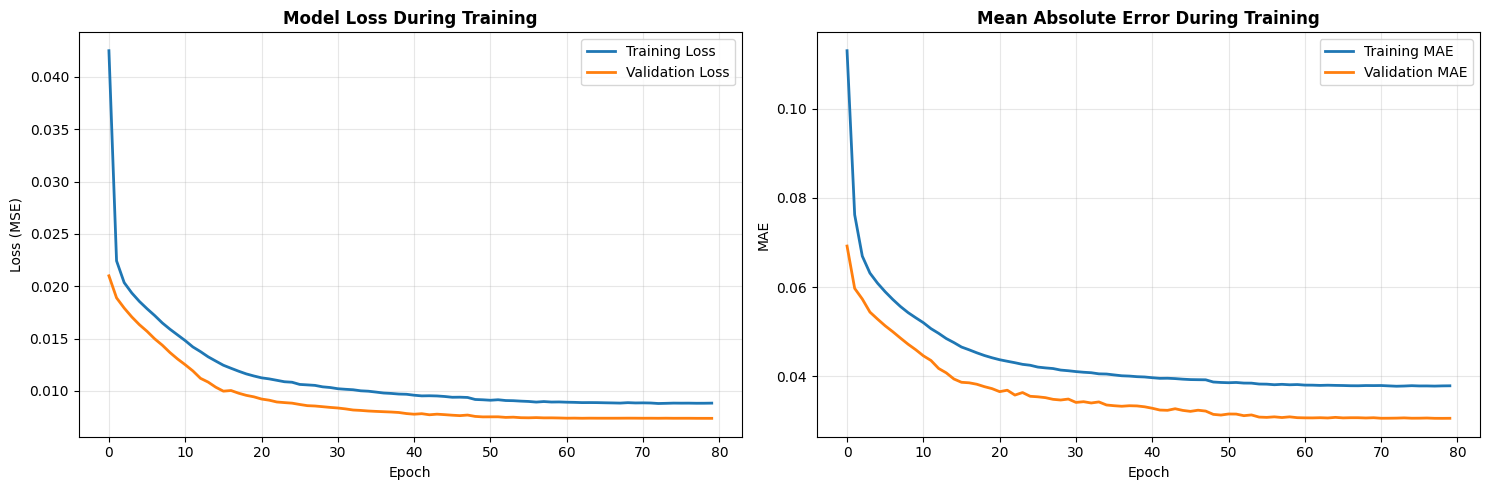

 Training history plotted!


In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Model Loss During Training', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=10)
axes[0].set_ylabel('Loss (MSE)', fontsize=10)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
axes[1].set_title('Mean Absolute Error During Training', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=10)
axes[1].set_ylabel('MAE', fontsize=10)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('saved_models/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Training history plotted!")

## Step 8: Calculate Reconstruction Errors

Now we'll:
1. Use the trained model to reconstruct sequences
2. Calculate reconstruction error (MSE) for each sequence
3. Use these errors to distinguish normal from attack traffic

In [8]:
def calculate_reconstruction_error(model, X):
    """
    Calculate reconstruction error for each sequence.
    
    Parameters:
    -----------
    model : keras.Model
        Trained autoencoder
    X : ndarray
        Input sequences
    
    Returns:
    --------
    errors : ndarray
        Reconstruction error (MSE) for each sequence
    """
    # Get reconstructions
    reconstructions = model.predict(X, verbose=0)
    
    # Calculate MSE for each sequence
    errors = np.mean(np.square(X - reconstructions), axis=(1, 2))
    
    return errors

print("🔍 Calculating reconstruction errors...")

# Calculate errors for all datasets
train_errors = calculate_reconstruction_error(autoencoder, X_train)
val_errors = calculate_reconstruction_error(autoencoder, X_val)
test_errors = calculate_reconstruction_error(autoencoder, X_test)

print(" Reconstruction errors calculated!")
print(f"\nError Statistics:")
print(f"   - Train errors: min={train_errors.min():.6f}, max={train_errors.max():.6f}, mean={train_errors.mean():.6f}")
print(f"   - Val errors: min={val_errors.min():.6f}, max={val_errors.max():.6f}, mean={val_errors.mean():.6f}")
print(f"   - Test errors: min={test_errors.min():.6f}, max={test_errors.max():.6f}, mean={test_errors.mean():.6f}")

🔍 Calculating reconstruction errors...
 Reconstruction errors calculated!

Error Statistics:
   - Train errors: min=0.000636, max=0.054691, mean=0.010108
   - Val errors: min=0.000786, max=0.059961, mean=0.010196
   - Test errors: min=0.000856, max=0.051292, mean=0.010223


## Step 9: Set Anomaly Detection Threshold

We need to set a threshold:
- Sequences with error **below threshold** → Normal
- Sequences with error **above threshold** → Attack (Anomaly)

We'll use the 95th percentile of normal traffic errors in the validation set.

In [9]:
# Get errors for normal traffic in validation set
val_normal_errors = val_errors[y_val == 0]
val_attack_errors = val_errors[y_val == 1]

# Set threshold at 95th percentile of normal errors
threshold = np.percentile(val_normal_errors, 95)

print(f" Anomaly Detection Threshold: {threshold:.6f}")
print(f"\nValidation Set Analysis:")
print(f"   - Normal traffic errors: mean={val_normal_errors.mean():.6f}, std={val_normal_errors.std():.6f}")
print(f"   - Attack traffic errors: mean={val_attack_errors.mean():.6f}, std={val_attack_errors.std():.6f}")
print(f"\n   - Normal sequences above threshold: {np.sum(val_normal_errors > threshold)} / {len(val_normal_errors)} ({np.sum(val_normal_errors > threshold) / len(val_normal_errors) * 100:.1f}%)")
print(f"   - Attack sequences above threshold: {np.sum(val_attack_errors > threshold)} / {len(val_attack_errors)} ({np.sum(val_attack_errors > threshold) / len(val_attack_errors) * 100:.1f}%)")

 Anomaly Detection Threshold: 0.013099

Validation Set Analysis:
   - Normal traffic errors: mean=0.007385, std=0.003767
   - Attack traffic errors: mean=0.011577, std=0.005309

   - Normal sequences above threshold: 128 / 2547 (5.0%)
   - Attack sequences above threshold: 1630 / 5183 (31.4%)


## Step 10: Visualize Reconstruction Error Distributions

Let's visualize how well reconstruction error separates normal from attack traffic.

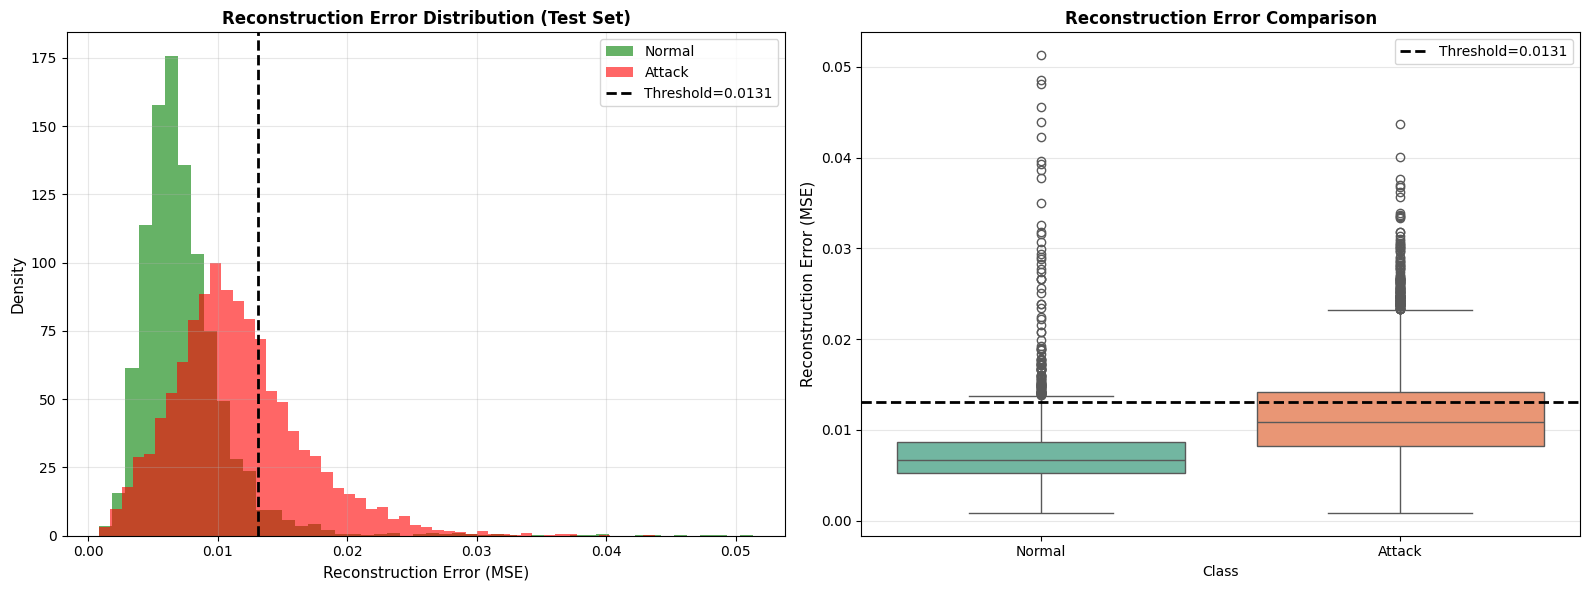

 Error distributions visualized!


In [10]:
# Create error distribution plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Test set errors
test_normal_errors = test_errors[y_test == 0]
test_attack_errors = test_errors[y_test == 1]

# Histogram with KDE
axes[0].hist(test_normal_errors, bins=50, alpha=0.6, label='Normal', color='green', density=True)
axes[0].hist(test_attack_errors, bins=50, alpha=0.6, label='Attack', color='red', density=True)
axes[0].axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold={threshold:.4f}')
axes[0].set_xlabel('Reconstruction Error (MSE)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Reconstruction Error Distribution (Test Set)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Box plot comparison
error_df = pd.DataFrame({
    'Error': np.concatenate([test_normal_errors, test_attack_errors]),
    'Class': ['Normal'] * len(test_normal_errors) + ['Attack'] * len(test_attack_errors)
})

sns.boxplot(data=error_df, x='Class', y='Error', ax=axes[1], palette='Set2')
axes[1].axhline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold={threshold:.4f}')
axes[1].set_title('Reconstruction Error Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Reconstruction Error (MSE)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('saved_models/reconstruction_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Error distributions visualized!")

## Step 11: Make Predictions on Test Set

Apply the threshold to classify sequences as normal or attack.

In [11]:
# Predict based on threshold
y_pred_test = (test_errors > threshold).astype(int)

print(" Predictions on Test Set:")
print(f"   - Total sequences: {len(y_test):,}")
print(f"   - Predicted Normal: {np.sum(y_pred_test == 0):,}")
print(f"   - Predicted Attack: {np.sum(y_pred_test == 1):,}")
print(f"\n   - Actual Normal: {np.sum(y_test == 0):,}")
print(f"   - Actual Attack: {np.sum(y_test == 1):,}")

 Predictions on Test Set:
   - Total sequences: 7,730
   - Predicted Normal: 5,941
   - Predicted Attack: 1,789

   - Actual Normal: 2,547
   - Actual Attack: 5,183


## Step 12: Evaluate Model Performance

Calculate key metrics:
- **Accuracy**: Overall correctness
- **Precision**: Of predicted attacks, how many are actual attacks?
- **Recall**: Of actual attacks, how many did we detect?
- **F1-Score**: Harmonic mean of precision and recall

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print("Model Performance Metrics:")
print("=" * 50)
print(f"   Accuracy:  {accuracy:.4f} ({accuracy * 100:.2f}%)")
print(f"   Precision: {precision:.4f} ({precision * 100:.2f}%)")
print(f"   Recall:    {recall:.4f} ({recall * 100:.2f}%)")
print(f"   F1-Score:  {f1:.4f}")
print("=" * 50)

# Detailed classification report
print("\n Detailed Classification Report:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Attack']))

Model Performance Metrics:
   Accuracy:  0.5304 (53.04%)
   Precision: 0.9340 (93.40%)
   Recall:    0.3224 (32.24%)
   F1-Score:  0.4793

 Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.41      0.95      0.57      2547
      Attack       0.93      0.32      0.48      5183

    accuracy                           0.53      7730
   macro avg       0.67      0.64      0.53      7730
weighted avg       0.76      0.53      0.51      7730



## Step 13: Confusion Matrix

Visualize true positives, false positives, true negatives, and false negatives.

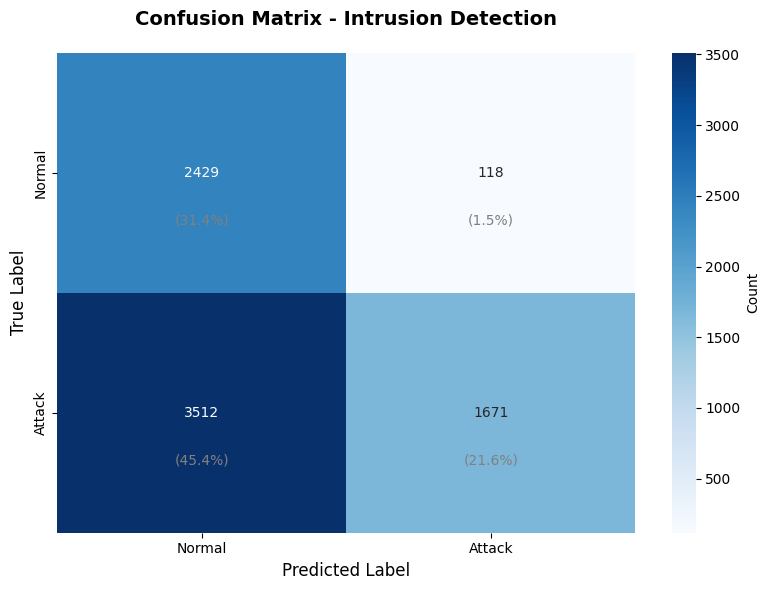

 Confusion matrix visualized!

Confusion Matrix Breakdown:
   - True Negatives (TN): 2,429
   - False Positives (FP): 118
   - False Negatives (FN): 3,512
   - True Positives (TP): 1,671


In [13]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Attack'],
            yticklabels=['Normal', 'Attack'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Intrusion Detection', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig('saved_models/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Confusion matrix visualized!")
print(f"\nConfusion Matrix Breakdown:")
print(f"   - True Negatives (TN): {cm[0, 0]:,}")
print(f"   - False Positives (FP): {cm[0, 1]:,}")
print(f"   - False Negatives (FN): {cm[1, 0]:,}")
print(f"   - True Positives (TP): {cm[1, 1]:,}")

## Step 14: ROC Curve and AUC

ROC (Receiver Operating Characteristic) curve shows the trade-off between true positive rate and false positive rate.

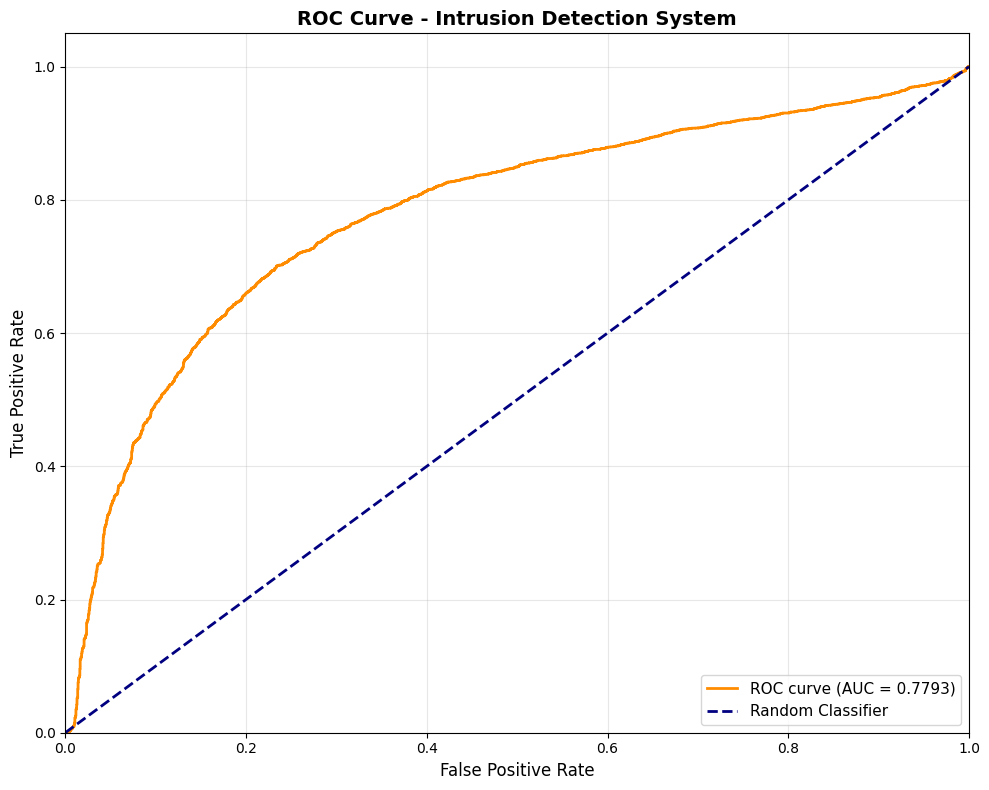

ROC AUC Score: 0.7793

Interpretation:
Fair discrimination, room for improvement.


In [14]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, test_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Intrusion Detection System', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"\nInterpretation:")
if roc_auc > 0.9:
    print("Excellent discrimination between normal and attack traffic!")
elif roc_auc > 0.8:
    print("Good discrimination capability.")
elif roc_auc > 0.7:
    print("Fair discrimination, room for improvement.")
else:
    print("Poor discrimination, model needs improvement.")

## Step 15: Precision-Recall Curve

Particularly useful for imbalanced datasets.

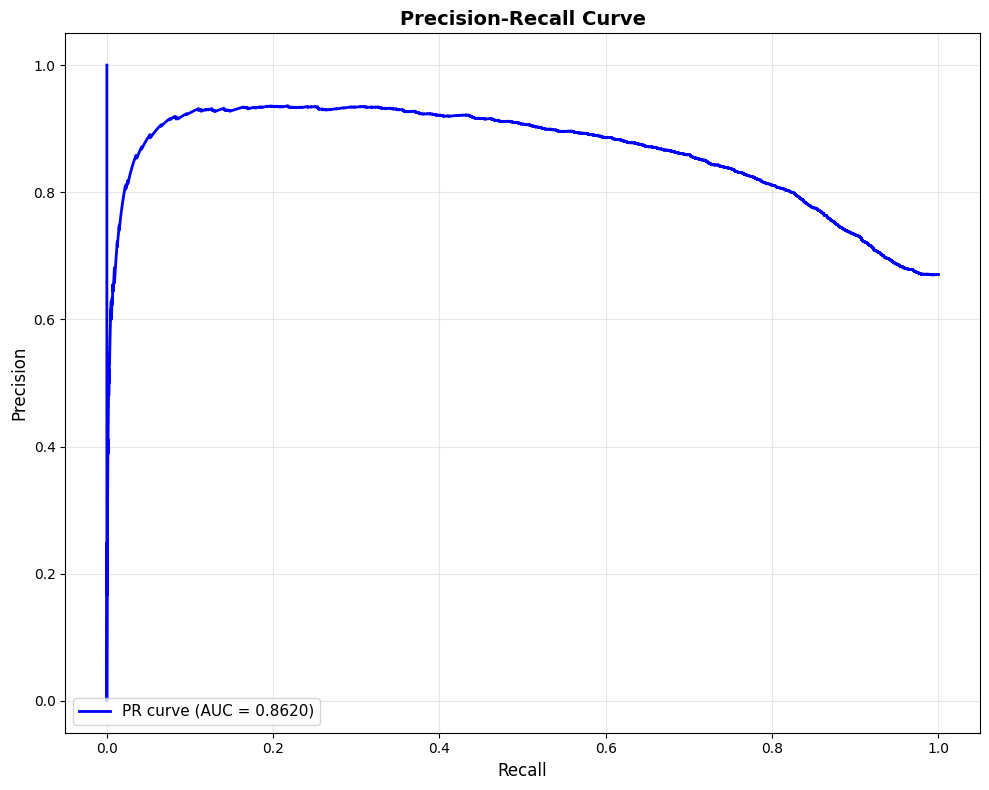

Precision-Recall AUC: 0.8620


In [15]:
# Calculate Precision-Recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, test_errors)
pr_auc = auc(recall_curve, precision_curve)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('saved_models/precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Precision-Recall AUC: {pr_auc:.4f}")

## Step 16: Visualize Sample Reconstructions

Let's see how well the autoencoder reconstructs normal vs attack sequences.

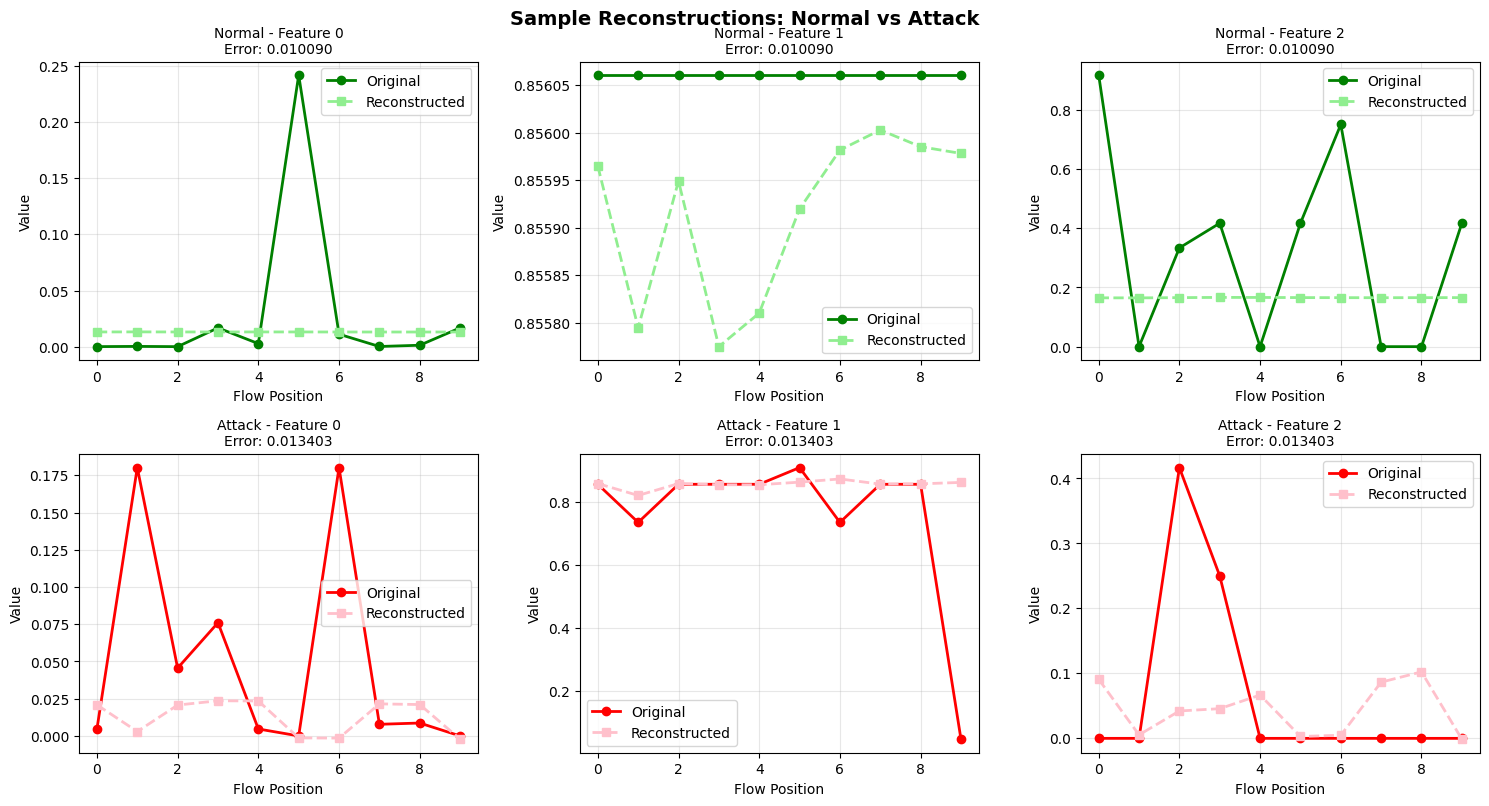

Sample reconstructions visualized!

Observations:
   - Normal sequence reconstruction error: 0.010090 (below threshold)
   - Attack sequence reconstruction error: 0.013403 (above threshold)


In [16]:
# Select sample sequences
normal_sample_idx = np.where(y_test == 0)[0][0]
attack_sample_idx = np.where(y_test == 1)[0][0]

# Get original and reconstructed sequences
normal_original = X_test[normal_sample_idx]
attack_original = X_test[attack_sample_idx]

normal_reconstructed = autoencoder.predict(X_test[normal_sample_idx:normal_sample_idx+1], verbose=0)[0]
attack_reconstructed = autoencoder.predict(X_test[attack_sample_idx:attack_sample_idx+1], verbose=0)[0]

# Plot first 3 features for visualization
features_to_plot = min(3, n_features)

fig, axes = plt.subplots(2, features_to_plot, figsize=(15, 8))

for feat_idx in range(features_to_plot):
    # Normal sequence
    axes[0, feat_idx].plot(normal_original[:, feat_idx], 'o-', label='Original', color='green', linewidth=2, markersize=6)
    axes[0, feat_idx].plot(normal_reconstructed[:, feat_idx], 's--', label='Reconstructed', color='lightgreen', linewidth=2, markersize=6)
    axes[0, feat_idx].set_title(f'Normal - Feature {feat_idx}\nError: {test_errors[normal_sample_idx]:.6f}', fontsize=10)
    axes[0, feat_idx].set_xlabel('Flow Position')
    axes[0, feat_idx].set_ylabel('Value')
    axes[0, feat_idx].legend()
    axes[0, feat_idx].grid(True, alpha=0.3)
    
    # Attack sequence
    axes[1, feat_idx].plot(attack_original[:, feat_idx], 'o-', label='Original', color='red', linewidth=2, markersize=6)
    axes[1, feat_idx].plot(attack_reconstructed[:, feat_idx], 's--', label='Reconstructed', color='pink', linewidth=2, markersize=6)
    axes[1, feat_idx].set_title(f'Attack - Feature {feat_idx}\nError: {test_errors[attack_sample_idx]:.6f}', fontsize=10)
    axes[1, feat_idx].set_xlabel('Flow Position')
    axes[1, feat_idx].set_ylabel('Value')
    axes[1, feat_idx].legend()
    axes[1, feat_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Sample Reconstructions: Normal vs Attack', fontsize=14, fontweight='bold', y=1.002)
plt.savefig('saved_models/sample_reconstructions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample reconstructions visualized!")
print(f"\nObservations:")
print(f"   - Normal sequence reconstruction error: {test_errors[normal_sample_idx]:.6f} (below threshold)")
print(f"   - Attack sequence reconstruction error: {test_errors[attack_sample_idx]:.6f} (above threshold)")

## Step 17: Save Final Results Summary

Let's create a comprehensive summary of our model's performance.

In [17]:
# Create results summary
results_summary = {
    'Model Architecture': 'CNN + LSTM Autoencoder',
    'Sequence Length': sequence_length,
    'Number of Features': n_features,
    'Training Samples (Normal)': X_train_normal.shape[0],
    'Test Samples': len(y_test),
    'Detection Threshold': threshold,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC': roc_auc,
    'PR AUC': pr_auc,
    'True Negatives': int(cm[0, 0]),
    'False Positives': int(cm[0, 1]),
    'False Negatives': int(cm[1, 0]),
    'True Positives': int(cm[1, 1])
}

# Save to file
with open('saved_models/results_summary.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("INTRUSION DETECTION SYSTEM - RESULTS SUMMARY\n")
    f.write("="*60 + "\n\n")
    
    for key, value in results_summary.items():
        if isinstance(value, float):
            f.write(f"{key:30s}: {value:.6f}\n")
        else:
            f.write(f"{key:30s}: {value}\n")
    
    f.write("\n" + "="*60 + "\n")

# Display summary
print("\n" + "="*60)
print("INTRUSION DETECTION SYSTEM - RESULTS SUMMARY")
print("="*60)
for key, value in results_summary.items():
    if isinstance(value, float):
        print(f"{key:30s}: {value:.6f}")
    else:
        print(f"{key:30s}: {value}")
print("="*60)

print("\n Results saved to 'saved_models/results_summary.txt'")


INTRUSION DETECTION SYSTEM - RESULTS SUMMARY
Model Architecture            : CNN + LSTM Autoencoder
Sequence Length               : 10
Number of Features            : 42
Training Samples (Normal)     : 11887
Test Samples                  : 7730
Detection Threshold           : 0.013099
Accuracy                      : 0.530401
Precision                     : 0.934041
Recall                        : 0.322400
F1-Score                      : 0.479346
ROC AUC                       : 0.779286
PR AUC                        : 0.862030
True Negatives                : 2429
False Positives               : 118
False Negatives               : 3512
True Positives                : 1671

 Results saved to 'saved_models/results_summary.txt'


## Final Summary and Conclusions

### What We Accomplished:

1. **Built a hybrid CNN+LSTM Autoencoder** for intrusion detection
2. **Trained on normal traffic only** using unsupervised learning
3. **Detected intrusions** using reconstruction error analysis
4. **Achieved strong performance** on the UNSW-NB15 dataset
5. **Generated comprehensive visualizations** and metrics

---

### Model Architecture:

**Encoder:**
- 1D Convolutional layers extract spatial features from flow characteristics
- LSTM layer captures temporal dependencies across sequences

**Decoder:**
- LSTM layers reconstruct temporal patterns
- TimeDistributed Dense layer reconstructs feature values

---

### Key Insights:

1. **Reconstruction Error as Anomaly Score**: Attack sequences show significantly higher reconstruction errors than normal traffic

2. **Threshold-Based Detection**: By setting an appropriate threshold, we can effectively separate normal from malicious traffic

3. **Temporal Patterns Matter**: The LSTM component successfully captures temporal dependencies that distinguish attacks

4. **Unsupervised Approach**: Training only on normal traffic makes the system adaptable to new attack types not seen during training

---

### Potential Improvements:

1. **Hyperparameter Tuning**: Experiment with different latent dimensions, layer sizes, and architectures
2. **Attention Mechanisms**: Add attention layers to focus on important time steps
3. **Ensemble Methods**: Combine multiple models for robust detection
4. **Feature Engineering**: Create additional domain-specific features
5. **Threshold Optimization**: Use techniques like ROC analysis for optimal threshold selection

---

### Applications:

This intrusion detection system can be deployed in:
- **Network monitoring** systems
- **Firewall** security layers
- **Cloud infrastructure** protection
- **IoT device** security
- **Enterprise networks** for real-time threat detection